# Estimating Phosim CPU Times: 
## What can we learn from Twinkles Run 1?

Twinkles Run 1 is 1227 visits, a subset of the observations of a Deep Drilling Field from the kraken-1042 Opsim simulation.  Each of the visits is simulated as a 30-second observation with Phosim.  Together, the 1227 runs of Phosim required about 4 CPU years on the SLAC batch farm.  The CPU time required per visit varied widely.  Some required only a few hours.  More than 100 visits (representing about one third of the total CPU time) never completed because they reached the 5-day CPU time limit for the batch hosts, and produced no output.  

Studying the dependence of the CPU time on the various inputs to the Phosim simulations has several motivations.  Certainly there's no sense in investing CPU time in a run that cannot finish with 5 CPU days.  And Run 1 was relatively modest in terms of resource requirements.  Essentially all 1227 simulations ran in parallel on the batch farm.  For Twinkles1 and 2, which will be much larger, the batch farm will not be able to run all of the simulations in parallel and the effective throughput could well be determined by the individual simulations that take the most CPU time, if they are allowed to hog the available hosts. Twinkles1 and 2 might run at NERSC, which has more hosts, but reportedly a 2-day CPU limit per host.  Absent some solution involving checkpointing, we may need to make judicious adjustments to the Phosim inputs for these runs.  Also, John Peterson has pointed out that we should not assume that all of the inputs to Phosim for Run 1 were sensible.

For this study, a number of Phosim inputs were extracted from the instance catalogs for the runs, and combined with execution time information from the batch farm.  The columns of the resulting csv file are described [here](https://github.com/DarkEnergyScienceCollaboration/Twinkles/issues/159).

This Notebook is based on Phil Marshall's [machine learning example](https://github.com/drphilmarshall/StatisticalMethods/blob/master/examples/SDSScatalog/Quasars.ipynb).

In [8]:
# For pretty plotting
# !pip install --upgrade seaborn

In [9]:
import pandas as pd
pd.set_option('display.max_columns', None)
%pylab inline
import seaborn as sns
sns.set()
import copy
from __future__ import print_function

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Reading the data

* This is a regression problem, to be able to predict the CPU time in terms of various metadata related to the runs.  These apparently are called "features" in machine learning terminology.  Also the CPU time will be referred to as the "response variable."

* Read in the data.  Here just selected columns are being read from the file.  *They may or may not be the most relevant.  Also, the filter and hostname columns would need to be converted to numerical values in order to be used.  And the runlimit column probably needs special treatment because it is clearly related to large CPU times*

In [57]:
run1meta = pd.read_csv("http://www.slac.stanford.edu/~digel/lsst/run1_metadata.csv",index_col=0,usecols=["obshistid","altitude",\
                                                "moonalt","moonphase","dist2moon","cputime",\
                                                "runlimit"])

# Omit the two runs that have not actually finished running (or been 
# terminated at the CPU time limit).  These are flagged with -999.0 in
# the input file.  Also omit the runs that reached the CPU limit:
run1meta = run1meta[(run1meta["cputime"] > 0.) & (run1meta["runlimit"] == 0)]


# Response variables: redshift
cputime = run1meta["cputime"]

# Features or attributes: photometric measurements
run1meta_features = copy.copy(run1meta)
del run1meta_features["cputime"]
run1meta_features.head()

,altitude,moonalt,moonphase,dist2moon,runlimit
obshistid,,,,,
1000185,70.8431,-36.2917,3.8842,124.4370,0
1163952,67.7483,-36.2197,3.8387,124.3299,0
1163962,66.0231,-36.0954,3.8129,124.2682,0
1163982,62.9989,-35.7332,3.7678,124.1589,0
1164008,59.1991,-35.0218,3.7114,124.0196,0


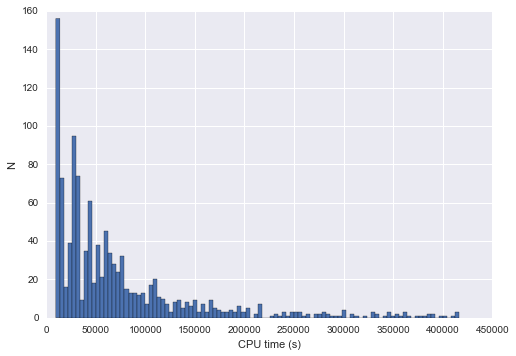

In [29]:
bins =  hist(cputime.values,bins=100) ; xlabel("CPU time (s)") ; ylabel("N")

The distribution of CPU time has a very long tail, plus a number of runs piled up at the 5-day CPU time limit.

Let's plot all the features, colored by the CPU time, to look for structure.  (Possibly the logarithm of the CPU time should be used.)

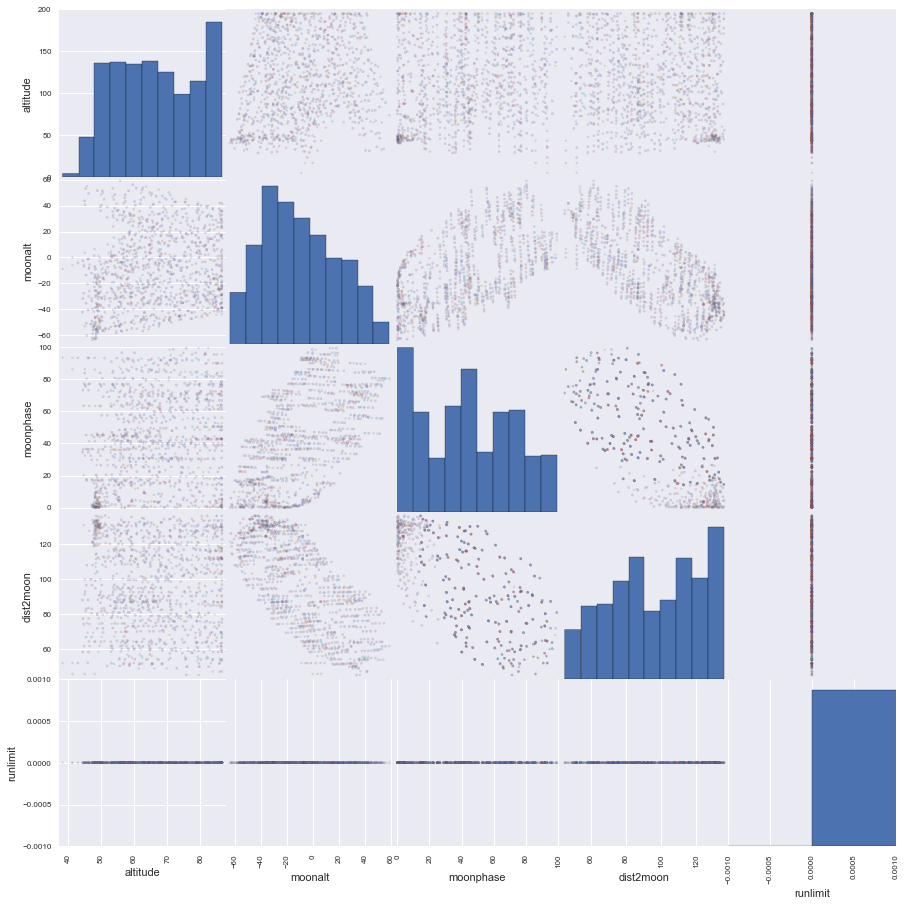

In [30]:
import matplotlib as mpl
import matplotlib.cm as cm

# Truncate the color at 3e5 CPU sec just to keep some contrast.
norm = mpl.colors.Normalize(vmin=min(qso_redshifts.values), vmax=300000)
cmap = cm.jet_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot everything against everything else:
rez = pd.scatter_matrix(run1meta_features[0:2000],alpha=0.2,figsize=[15,15],color=m.to_rgba(qso_redshifts.values))

Now we have our machine learning inputs and outputs:

In [33]:
X = run1meta_features.values  # Data: 5-d feature space
y = cputime.values # Target: redshifts

In [34]:
print("Design matrix shape =", X.shape)
print("Response variable vector shape =", y.shape)

Design matrix shape = (1121, 5)
Response variable vector shape = (1121,)


In [35]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Linear Regression

Let's follow the same procedure as in the [`SciKit-Learn` tutorial](../../scikit-learn/Linear_Regression.ipynb) we just went through:

In [36]:
from sklearn import linear_model
linear = linear_model.LinearRegression()

# Fit the model, using all the attributes:
linear.fit(X_train, y_train)

# Do the prediction on the test data:
y_lr_pred = linear.predict(X_test)

# How well did we do?
from sklearn.metrics import mean_squared_error
mse_linear = np.sqrt(mean_squared_error(y_test,y_lr_pred))
r2_linear = linear.score(X_test, y_test)
print("Linear regression: MSE = ",mse_linear)
print("R2 score =",r2_linear)

Linear regression: MSE =  56455.532082
R2 score = 0.386451660234


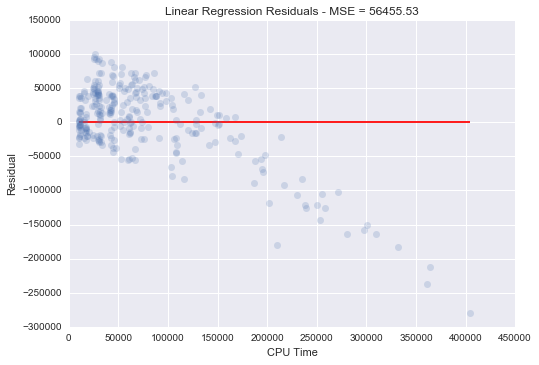

In [37]:
plot(y_test,y_lr_pred - y_test,'o',alpha=0.2)
title("Linear Regression Residuals - MSE = %.2f" % mse_linear)
xlabel("CPU Time")
ylabel("Residual")
hlines(0,min(y_test),max(y_test),color="red")

Just how bad is this? Here's the MSE from guessing the *average redshift of the training set* for all new objects:

In [38]:
print("Naive MSE", ((1./len(y_train))*(y_train - y_train.mean())**2).sum())
print("Linear regression: MSE = ",mse_linear)

Naive MSE 6337966157.68
Linear regression: MSE =  56455.532082


In [17]:
mean_squared_error?

### *k*-Nearest Neighbor (KNN) Regression

Now let's try a different kind of model: a *non-parametric* one.

["Regression based on k-nearest neighbors. The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set."](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)


#### Question:

What underlying model is implied by the KNN algorithm? How many hidden parameters does it have?

In [39]:
from sklearn import neighbors
from sklearn import preprocessing

X_scaled = preprocessing.scale(X) # Many methods work better on scaled X.

KNN = neighbors.KNeighborsRegressor(5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

KNN.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [40]:
y_knn_pred = KNN.predict(X_test)
mse_knn = mean_squared_error(y_test,y_knn_pred)
r2_knn = KNN.score(X_test, y_test)
print("MSE (KNN) =", mse_knn)
print("R2 score (KNN) =",r2_knn)
print("cf.")
print("MSE (linear regression) = ",mse_linear)
print("R2 score (linear regression) =",r2_linear)

MSE (KNN) = 2879675701.73
R2 score (KNN) = 0.465874193265
cf.
MSE (linear regression) =  56455.532082
R2 score (linear regression) = 0.386451660234


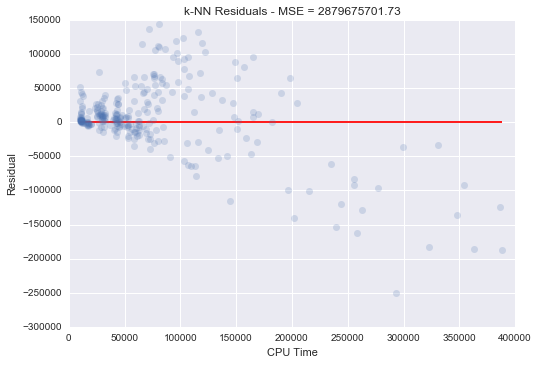

In [41]:
plot(y_test, y_knn_pred - y_test,'o',alpha=0.2)
title("k-NN Residuals - MSE = %.2f" % mse_knn)
xlabel("CPU Time")
ylabel("Residual")
hlines(0,min(y_test),max(y_test),color="red")

### Tuning the KNN Model

* Let's vary the control parameters of the KNN model, to see how good we can make our predictions.

* We can see our options in the model `repr`:

> KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_neighbors=5, p=2, weights='uniform')

* Let's first make a "validation curve" to investigate one parameter: the number of nearest neighbors averaged over.

In [42]:
# We'll vary the number of neighbors used:
param_name = "n_neighbors"
param_range = np.array([1,2,4,8,16,32,64])

# And we'll need a cv iterator:
from sklearn.cross_validation import ShuffleSplit
shuffle_split = ShuffleSplit(len(X), 10, test_size=0.4)

# Compute our cv scores for a range of the no. of neighbors:
from sklearn.learning_curve import validation_curve
training_scores, validation_scores = validation_curve(KNN, X_scaled, y,
                                                      param_name=param_name,
                                                      param_range=param_range, 
                                                      cv=shuffle_split, scoring='r2')

In [43]:
def plot_validation_curve(param_name,parameter_values, training_scores, validation_scores):
    training_scores_mean = np.mean(training_scores, axis=1)
    training_scores_std = np.std(training_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, training_scores_mean - training_scores_std,
                     training_scores_mean + training_scores_std, alpha=0.1, color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, training_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, training_scores_mean.max() + .1)
    plt.xlabel(param_name)
    plt.legend(loc="best")

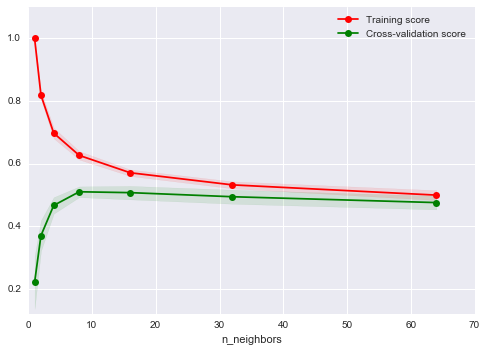

In [44]:
plot_validation_curve(param_name, param_range, training_scores, validation_scores)

#### Question:

Can you explain the shapes of these two curves? Talk to your neighbor for a few minutes, and be prepared to suggest reasons for a) the rise and fall of the cross validation score and b) the monotonic decrease in training score.

#### Model tuning with `GridSearchCV`

* Now, let's see if we can do better by varying some other KNN options as well - in a *grid search*.

In [45]:
param_grid = {'n_neighbors': np.array([1,2,4,8,16,32,64]),
                  'weights': ['uniform','distance'],
                       'p' : np.array([1,2])}

np.set_printoptions(suppress=True)
print(param_grid)

{'n_neighbors': array([ 1,  2,  4,  8, 16, 32, 64]), 'weights': ['uniform', 'distance'], 'p': array([1, 2])}


In [46]:
from sklearn.grid_search import GridSearchCV
KNN_tuned = GridSearchCV(KNN, param_grid, verbose=3)

A `GridSearchCV` object behaves just like a model, except it carries out a cross-validation while fitting:

<img src="../../scikit-learn/figures/grid_search_cross_validation.svg" width=100%>

In [47]:
KNN_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.166832 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.297818 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.344628 -   0.0s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.166832 -   0.0s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.297818 -   0.0s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.344628 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neig

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.541174 -   0.0s
[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.510222 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.482653 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.549080 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.517694 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.474375 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.537183 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=64, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  4,  8, 16, 32, 64]), 'weights': ['uniform', 'distance'], 'p': array([1, 2])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [48]:
y_knn_tuned_pred = KNN_tuned.predict(X_test)

mse_knn_tuned = mean_squared_error(y_test,y_knn_tuned_pred)
r2_knn_tuned = KNN_tuned.score(X_test, y_test)

print("MSE (tuned KNN) =", mse_knn_tuned)
print("R2 score (tuned KNN) =",r2_knn_tuned)
print("cf.")
print("MSE (KNN) = ",mse_knn)
print("R2 score (KNN) =",r2_knn)

MSE (tuned KNN) = 2626514941.95
R2 score (tuned KNN) = 0.512830763746
cf.
MSE (KNN) =  2879675701.73
R2 score (KNN) = 0.465874193265


Which are the best KNN control parameters we found?

In [49]:
KNN_tuned.best_params_

{'n_neighbors': 16, 'p': 1, 'weights': 'distance'}

This value of `n_neighbors` is consistent with the peak in cross-validation score in the validation curve plot.

#### Generalization Error

Notice that all the above tuning happened while training on a single split (`X_train` and `y_train`).


It's possible that that particular fold prefers a slightly different set of parameters than a different one - so to assess our generalization error, we need a further level of cross-validation.


We can do this by passing a `GridSearchCV` model to the cross validation score calculator. This will take a few moments, as the grid search is carried out for each CV fold...

In [50]:
from sklearn.cross_validation import cross_val_score

R2 = cross_val_score(KNN_tuned, X_scaled, y, cv=shuffle_split, scoring='r2')

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] ... n_neighbors=1, weights=uniform, p=1, score=-0.187424 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.138043 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.338074 -   0.0s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] .. n_neighbors=1, weights=distance, p=1, score=-0.187424 -   0.0s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.138043 -   0.0s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.338074 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] ... n_neigh

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] ... n_neighbors=4, weights=distance, p=2, score=0.449522 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.510808 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.273208 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.472414 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.495019 -   0.0s
[CV] n_neighbors=8, weights=distance, p=1 ............................
[CV] ... n_neighbors=8, weights=distance, p=1, score=0.288367 -   0.0s
[CV] n_neighbors=8, weights=distance, p=1 ............................
[CV] ... n_neighbors=8, weights=distance, p=1, score=0.471685 -   0.0s
[CV] n_neighbors=8, weights=distance, p=1 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s


[CV] ... n_neighbors=2, weights=distance, p=1, score=0.169716 -   0.0s
[CV] n_neighbors=2, weights=distance, p=1 ............................
[CV] ... n_neighbors=2, weights=distance, p=1, score=0.394671 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=2 .............................
[CV] .... n_neighbors=2, weights=uniform, p=2, score=0.450302 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=2 .............................
[CV] .... n_neighbors=2, weights=uniform, p=2, score=0.159095 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=2 .............................
[CV] .... n_neighbors=2, weights=uniform, p=2, score=0.476308 -   0.0s
[CV] n_neighbors=2, weights=distance, p=2 ............................
[CV] ... n_neighbors=2, weights=distance, p=2, score=0.417643 -   0.0s
[CV] n_neighbors=2, weights=distance, p=2 ............................
[CV] ... n_neighbors=2, weights=distance, p=2, score=0.138543 -   0.0s
[CV] n_neighbors=2, weights=distance, p=2 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.508195 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.509056 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.400620 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.513160 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.558531 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.417390 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.504174 -   0.0s
[CV] n_neighbors=8, weights=distance, p=1 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.222537 -   0.0s
[CV] n_neighbors=1, weights=distance, p=2 ............................
[CV] ... n_neighbors=1, weights=distance, p=2, score=0.228233 -   0.0s
[CV] n_neighbors=1, weights=distance, p=2 ............................
[CV] ... n_neighbors=1, weights=distance, p=2, score=0.139161 -   0.0s
[CV] n_neighbors=1, weights=distance, p=2 ............................
[CV] ... n_neighbors=1, weights=distance, p=2, score=0.222537 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=1 .............................
[CV] .... n_neighbors=2, weights=uniform, p=1, score=0.330425 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=1 .............................
[CV] .... n_neighbors=2, weights=uniform, p=1, score=0.413598 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=1 .............................
[CV] .... n_neighbors=2, weights=uniform, p=1, score=0.384119 -   0.0s
[CV] n_neighbors=2, weights=distance, p=1 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] .... n_neighbors=4, weights=uniform, p=1, score=0.420462 -   0.0s
[CV] n_neighbors=4, weights=uniform, p=1 .............................
[CV] .... n_neighbors=4, weights=uniform, p=1, score=0.446687 -   0.0s
[CV] n_neighbors=4, weights=distance, p=1 ............................
[CV] ... n_neighbors=4, weights=distance, p=1, score=0.512299 -   0.0s
[CV] n_neighbors=4, weights=distance, p=1 ............................
[CV] ... n_neighbors=4, weights=distance, p=1, score=0.383906 -   0.0s
[CV] n_neighbors=4, weights=distance, p=1 ............................
[CV] ... n_neighbors=4, weights=distance, p=1, score=0.482856 -   0.0s
[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.471919 -   0.0s
[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.383475 -   0.0s
[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.7s finished


[CV] .... n_neighbors=2, weights=uniform, p=1, score=0.485549 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=1 .............................
[CV] .... n_neighbors=2, weights=uniform, p=1, score=0.215301 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=1 .............................
[CV] .... n_neighbors=2, weights=uniform, p=1, score=0.300848 -   0.0s
[CV] n_neighbors=2, weights=distance, p=1 ............................
[CV] ... n_neighbors=2, weights=distance, p=1, score=0.479001 -   0.0s
[CV] n_neighbors=2, weights=distance, p=1 ............................
[CV] ... n_neighbors=2, weights=distance, p=1, score=0.224629 -   0.0s
[CV] n_neighbors=2, weights=distance, p=1 ............................
[CV] ... n_neighbors=2, weights=distance, p=1, score=0.288343 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=2 .............................
[CV] .... n_neighbors=2, weights=uniform, p=2, score=0.437192 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=2 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.494800 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.561766 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.395223 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.479646 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.532499 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.494610 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.505825 -   0.0s
[CV] n_neighbors=8, weights=distance, p=1 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.7s finished


Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.274619 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.207286 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.066534 -   0.0s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.274619 -   0.0s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.207286 -   0.0s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.066534 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neig

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.315589 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.457557 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.399529 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.331965 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.473438 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.426916 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.358413 -   0.0s
[CV] n_neighbors=8, weights=distance, p=1 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.349455 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.518320 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.436945 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.375701 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.573528 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.394619 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.390979 -   0.0s
[CV] n_neighbors=8, weights=distance, p=1 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.5s finished


[CV] ... n_neighbors=1, weights=distance, p=2, score=0.063131 -   0.0s
[CV] n_neighbors=1, weights=distance, p=2 ............................
[CV] ... n_neighbors=1, weights=distance, p=2, score=0.218178 -   0.0s
[CV] n_neighbors=1, weights=distance, p=2 ............................
[CV] ... n_neighbors=1, weights=distance, p=2, score=0.290618 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=1 .............................
[CV] .... n_neighbors=2, weights=uniform, p=1, score=0.297455 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=1 .............................
[CV] .... n_neighbors=2, weights=uniform, p=1, score=0.340759 -   0.0s
[CV] n_neighbors=2, weights=uniform, p=1 .............................
[CV] .... n_neighbors=2, weights=uniform, p=1, score=0.392755 -   0.0s
[CV] n_neighbors=2, weights=distance, p=1 ............................
[CV] ... n_neighbors=2, weights=distance, p=1, score=0.283591 -   0.0s
[CV] n_neighbors=2, weights=distance, p=1 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] ... n_neighbors=8, weights=distance, p=1, score=0.475995 -   0.0s
[CV] n_neighbors=8, weights=distance, p=1 ............................
[CV] ... n_neighbors=8, weights=distance, p=1, score=0.502357 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=2 .............................
[CV] .... n_neighbors=8, weights=uniform, p=2, score=0.526821 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=2 .............................
[CV] .... n_neighbors=8, weights=uniform, p=2, score=0.435036 -   0.0s
[CV] n_neighbors=8, weights=uniform, p=2 .............................
[CV] .... n_neighbors=8, weights=uniform, p=2, score=0.504616 -   0.0s
[CV] n_neighbors=8, weights=distance, p=2 ............................
[CV] ... n_neighbors=8, weights=distance, p=2, score=0.531133 -   0.0s
[CV] n_neighbors=8, weights=distance, p=2 ............................
[CV] ... n_neighbors=8, weights=distance, p=2, score=0.470656 -   0.0s
[CV] n_neighbors=8, weights=distance, p=2 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] n_neighbors=2, weights=distance, p=2 ............................
[CV] ... n_neighbors=2, weights=distance, p=2, score=0.415684 -   0.0s
[CV] n_neighbors=2, weights=distance, p=2 ............................
[CV] ... n_neighbors=2, weights=distance, p=2, score=0.417418 -   0.0s
[CV] n_neighbors=2, weights=distance, p=2 ............................
[CV] ... n_neighbors=2, weights=distance, p=2, score=0.393830 -   0.0s
[CV] n_neighbors=4, weights=uniform, p=1 .............................
[CV] .... n_neighbors=4, weights=uniform, p=1, score=0.475472 -   0.0s
[CV] n_neighbors=4, weights=uniform, p=1 .............................
[CV] .... n_neighbors=4, weights=uniform, p=1, score=0.511633 -   0.0s
[CV] n_neighbors=4, weights=uniform, p=1 .............................
[CV] .... n_neighbors=4, weights=uniform, p=1, score=0.493535 -   0.0s
[CV] n_neighbors=4, weights=distance, p=1 ............................
[CV] ... n_neighbors=4, weights=distance, p=1, score=0.479008 -   0.0s
[CV] n

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.5s finished


In [51]:
meanR2,errR2 = np.mean(R2),np.std(R2)
print("Mean score:",meanR2,"+/-",errR2)

Mean score: 0.535228648124 +/- 0.0220963428764


### Notes

* Optimizing over control parameters (or hyper parameters) with grid search cross validation is a form of model selection.


* When presented with new metadata samples, and asked to predict the target response variables (CPU time), we'll need a trained machine that has not been *over-fitted* to the training data.


* Minimizing and estimating the generalization error is a way to reduce the risk of getting this prediction wrong. 


* Let's finish off our CPU time machine-learning algorithm.

In [52]:
KNNz = KNN_tuned.best_estimator_
KNNz.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=16, p=1,
          weights='distance')

In [54]:
j = 71
one_pretend_run = X_test[j,:]
cpupredicted = KNNz.predict(one_pretend_run)
cpuactual = y_test[j]
print("True CPU cf. KNN predicted CPU time:",cpuactual,cpupredicted)

True CPU cf. KNN predicted CPU time: 19496.55 [ 20894.8096685]


/Users/digel/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


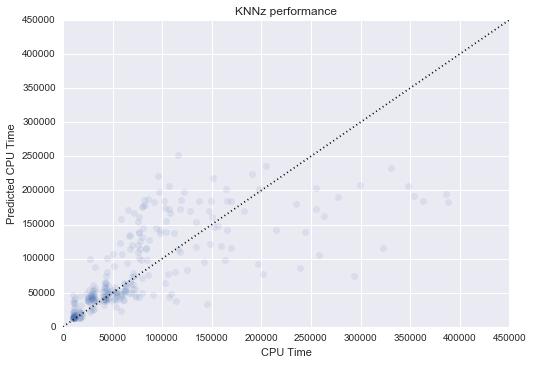

In [56]:
cpuactual = y_test
cpupredicted = KNNz.predict(X_test)

plot(cpuactual, cpupredicted,'o',alpha=0.1)
title("KNNz performance")
xlabel("CPU Time")
ylabel("Predicted CPU Time")
lims = [0.0,450e3]
xlim(lims)
ylim(lims)
plot(lims, lims, ':k')

## Quasar Classification with Random Forests


* Let's switch gears and do a 3-class classification problem: star, galaxy, or QSO.


* A very good general-purpose classification (and regression!) algorithm is Random Forest. See [this blog post](http://blog.yhathq.com/posts/random-forests-in-python.html) for a nice high level introduction.


* ["A random forest is a meta estimator that fits a number of *decision tree classifiers* on various sub-samples of the dataset, and uses averaging to improve the predictive accuracy and control over-fitting.](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


* Let's read in equal numbers of all three types of data, clean them up, and set $y$ equal to the classification label.

In [34]:
all_sources = pd.read_csv("data/qso10000.csv",index_col=0,usecols=["objid","dered_r","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z","class"])[:1000]

all_sources = all_sources.append(pd.read_csv("data/star1000.csv",index_col=0,usecols=["objid","dered_r","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z","class"]))

all_sources = all_sources.append(pd.read_csv("data/galaxy1000.csv",index_col=0,usecols=["objid","dered_r","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z","class"]))

all_sources = all_sources[(all_sources["dered_r"] > -9999) & (all_sources["g_r_color"] > -10) & (all_sources["g_r_color"] < 10)]

all_labels = all_sources["class"]

all_features = copy.copy(all_sources)
del all_features["class"]

X = copy.copy(all_features.values)
y = copy.copy(all_labels.values)

In [35]:
all_labels.tail()

objid
1237657775542632759    GALAXY
1237657775542698090    GALAXY
1237657775542698177    GALAXY
1237657630586634463    GALAXY
1237657630049698007    GALAXY
Name: class, dtype: object

In [36]:
print("Feature vector shape =", X.shape)
print("Class label vector shape =", y.shape)

Feature vector shape = (3000, 9)
Class label vector shape = (3000,)


What structure can we see in the data? Let's plot all the features as before.

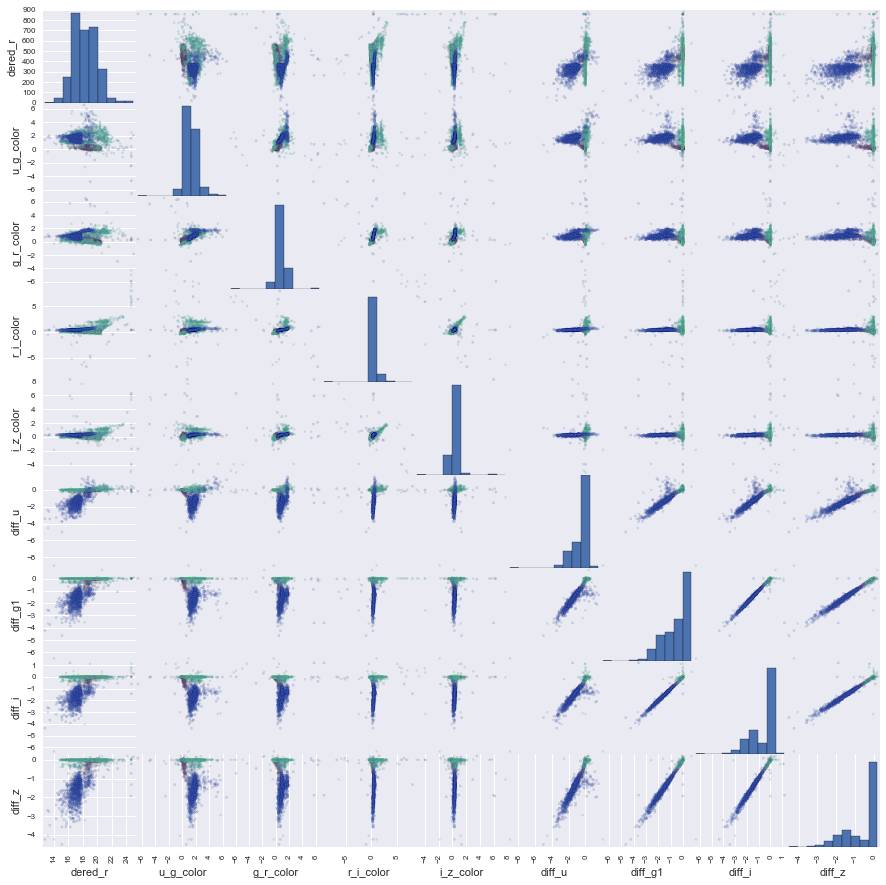

In [37]:
yy = all_labels.values.copy()
yy[yy=="QSO"] = 0.0    # Red
yy[yy=="STAR"] = 0.5   # Green
yy[yy=="GALAXY"] = 1.0 # Blue

norm = mpl.colors.Normalize(vmin=min(yy), vmax=max(yy))
cmap = cm.jet_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)
rez = pd.scatter_matrix(all_features,alpha=0.2,figsize=[15,15],color=m.to_rgba(yy))

OK - looks like there is information there to be used! 
Let's turn on the machine learning.

### Random Forest Classification

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,oob_score=True)
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

What are the important features in the data?

In [39]:
sorted(zip(all_sources.columns.values,rf.feature_importances_),key=lambda q: q[1],reverse=True)

[('u_g_color', 0.28475690579817575),
 ('diff_g1', 0.17348031019127119),
 ('diff_z', 0.13998745226053377),
 ('diff_i', 0.12920333337382961),
 ('g_r_color', 0.078688700291527802),
 ('diff_u', 0.059468683917175573),
 ('r_i_color', 0.058087542102404112),
 ('dered_r', 0.046524797276633431),
 ('i_z_color', 0.029802274788448834)]

In [40]:
rf.oob_score_

0.95266666666666666

This is the "Out of Bag" accuracy (of predicted y compared to truth), made available by ensemble classifiers. (Each decision tree in the ensemble is only working on a subset of the data, so it can track its accuracy with the data not in its own bag.) 

The accuracy of a classifier is the fraction of predictions made that are correct. This one looks like its doing well - but this is the accuracy on the training set.

### Classifier improvement with GridSearchCV

In [41]:
# Parameter values to try:
parameters = {'n_estimators':(50,100,200),"max_features": ["auto",3],
              'criterion':["gini","entropy"],"min_samples_leaf": [1,2]}

# Initial training/test split:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [42]:
# Do a grid search to find the highest 3-fold CV score:
rf_tuned = GridSearchCV(rf, parameters, cv=3, verbose=1)
RFselector = rf_tuned.fit(X_train, y_train)

# Print the best score and estimator:
print(RFselector.best_score_)
print(RFselector.best_estimator_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   42.6s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.2min finished


0.950222222222
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


#### Question:

Would you be satisfied with a 95% successful classification fraction? Read the Random Forest `SciKit-Learn` docs to find some alternative scores, and think about when you might want to choose one of these instead. (Hint: imagine using a classifier to select a sample of *targets*.)

One way of visualizing classification accuracy is via a *confusion matrix*:

In [43]:
y_pred = RFselector.predict(X_test)

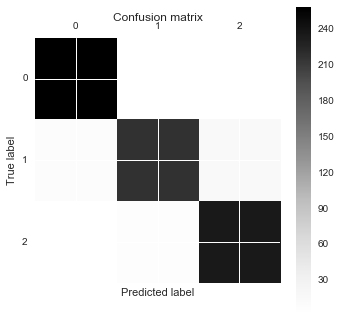

In [44]:
# Compute confusion matrix:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Each output label comes with a *classification probability*, computed from the results of the whole forest. To select a sample of classified objects, one can choose a selection threshold in this class probability, and only keep objects with higher probability than this threshold.


The availability of a class probability leads to an important diagnostic: the "Receiver Operating Characteristic" or ["ROC" curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). This shows the *true positive rate* (TPR) plotted against the *false positive rate* (FPR) of a classifier, as the selection threshold is varied.


Typically, classifiers have control parameters that affect both the TPR and FPR (often improving one at the expense of the other), so the ROC curve is a good tool for investigating these parameters. 


Likewise, ROC curves provide a very good way to compare different classifiers.

### Exercise:

Use `SciKit-Learn` utilities to plot an ROC curve for the RFselector.

**[Back to the lesson plan](../../lessons/9.MachineLearning.ipynb)**